# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Getting Started

In [40]:
# import libraries
from helper import *
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import datetime
import matplotlib.patches as mpatches

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
np.random.seed(43)

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration 

In [41]:
# view data as it was read in
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Portfolio: In addition to the user id, the portfolio data has 3 numeric variables as well as two nominal categorical variables that will need to be one-hot-encoded to get dummies.

In [42]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


Profile: The profile data also includes the user id. There are missing values for both gender and income. Gender will need to be one-hot-encoded as well. Additionally, "became_member_on" will need to be reformatted using datetime.

In [43]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


Transcript: The transcript data calls the user id "person" instead, which will be important to remember when combining the datasets. Event will need to be one-hot-encoded. Value and time need to be further explored.  

## Portfolio Cleanup

**portfolio.json** -  containing offer ids and meta data about each offer (duration, type, etc.)

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [44]:
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,168,bogo,B1,1,1,1,0,1,0,0
1,10,10,120,bogo,B2,1,1,1,1,1,0,0
2,0,0,96,informational,I1,1,1,0,1,0,0,1
3,5,5,168,bogo,B3,1,1,0,1,1,0,0
4,5,20,240,discount,D1,1,0,0,1,0,1,0
5,3,7,168,discount,D2,1,1,1,1,0,1,0
6,2,10,240,discount,D3,1,1,1,1,0,1,0
7,0,0,72,informational,I2,1,1,1,0,0,0,1
8,5,5,120,bogo,B4,1,1,1,1,1,0,0
9,2,10,168,discount,D4,1,1,0,1,0,1,0


## Profile Cleanup

**profile.json** - demographic data for each customer
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [45]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

I see that 'gender' and 'income' have the same number of missing values. From the description of data, I know that missing values for 'age' are encoded as 118. So I checked and found the same number of missing values for 'age'. With so much missing data for these observations, I will just drop these. 

Having the membership date in the correct format will make it easier to work with, but still doesn't help me much in terms of visualizing this feature. I'd like to know how long the user has been a member, which can be formated as a simple integer. (https://stackoverflow.com/questions/53867536/pandas-subtracting-current-date-from-the-date-in-a-pandas-table) 

In [46]:
cleaned_profile = clean_profile(profile)
cleaned_profile

,gender,age,customer_id,became_member_on,income,F,M,O,member_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,2404
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,2471
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0,2119
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0,2195
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0,2285
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1,0,0,2080
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,1,0,2041
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0,2574
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1,0,0,2899


In [47]:
cleaned_profile.describe()

,age,income,F,M,O,member_days
count,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000
mean,54.377800,65404.183536,0.413225,0.572470,0.014305,2550.489541
std,17.365541,21598.763284,0.492429,0.494737,0.118749,419.227316
min,18.000000,30000.000000,0.000000,0.000000,0.000000,2028.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000,2236.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000,2386.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000,2825.000000
max,100.000000,120000.000000,1.000000,1.000000,1.000000,3851.000000


Viewing these descriptive statistics, we can see that the average customer in the dataset is a 54 year old man with an average income of 65,404, who has been a member for 2454 days. 

## Transcript Cleanup

**transcript.json** - records for transactions, offers received, offers viewed, and offers completed
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [48]:
offers, transactions = clean_transcript(transcript)

In [49]:
offers

,customer_id,offer_id,event,hours,offer_received,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,B3,offer received,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,D1,offer received,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,D4,offer received,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,D3,offer received,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,B2,offer received,0,1,0,0
...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,D2,offer completed,714,0,0,1
306506,b895c57e8cd047a8872ce02aa54759d6,D3,offer completed,714,0,0,1
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,D1,offer viewed,714,0,1,0
306509,8431c16f8e1d440880db371a68f82dd0,D3,offer completed,714,0,0,1


In [50]:
offers['customer_id'].nunique()

16994

In [51]:
transactions

,customer_id,hours,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53
306531,a00058cf10334a308c68e7631c529907,714,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53


# Exploratory Analysis

### Cleaned_Profile

In [52]:
cleaned_profile

,gender,age,customer_id,became_member_on,income,F,M,O,member_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,2404
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,2471
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0,2119
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0,2195
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0,2285
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1,0,0,2080
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,1,0,2041
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0,2574
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1,0,0,2899


Questions of interest:
1. Distribution by income, age, length of membership
2. Distribution of successful vs unsuccessful offers by ^above^


I would need to:
1. Nothing for question 1, all that info is available
2. Combine profile and offers for question 2 

In [53]:
cleaned_profile.describe()

,age,income,F,M,O,member_days
count,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000
mean,54.377800,65404.183536,0.413225,0.572470,0.014305,2550.489541
std,17.365541,21598.763284,0.492429,0.494737,0.118749,419.227316
min,18.000000,30000.000000,0.000000,0.000000,0.000000,2028.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000,2236.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000,2386.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000,2825.000000
max,100.000000,120000.000000,1.000000,1.000000,1.000000,3851.000000


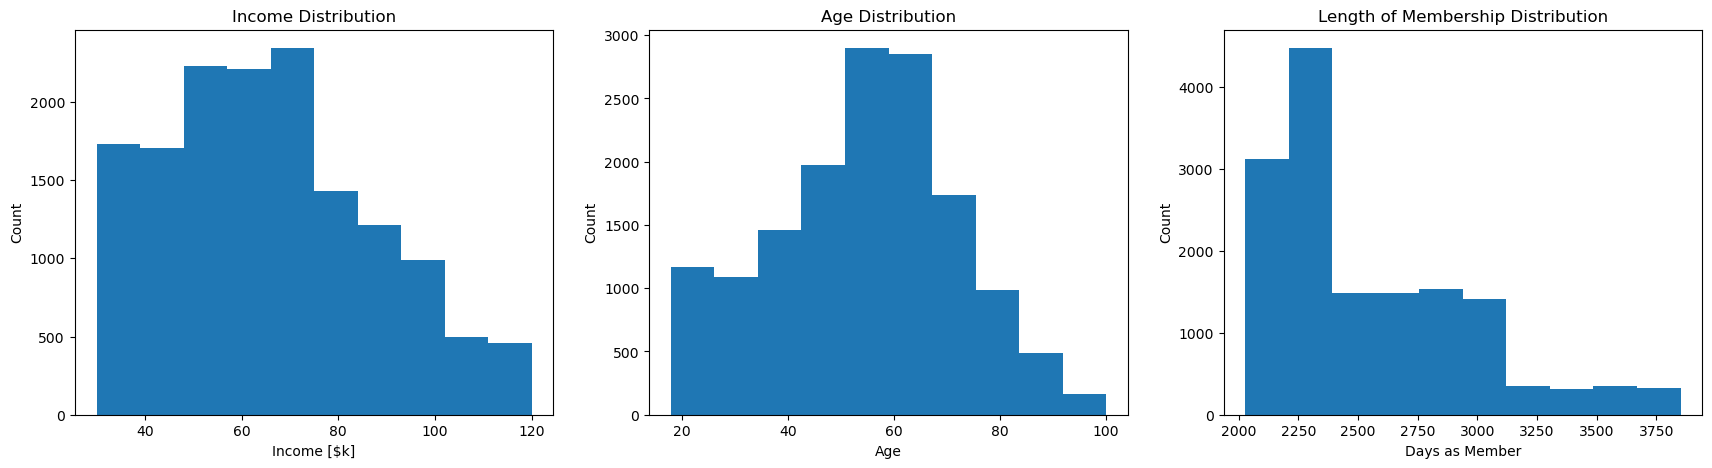

In [56]:
# Chart out plots side by side
fig, ax = plt.subplots(figsize=(21, 5), nrows=1, ncols=3)

gender = ['orange','green','purple']

# Income Distribution Plot
plt.sca(ax[0])
plt.hist(cleaned_profile['income'] * 1E-3)
plt.xlabel('Income [$k]')
plt.ylabel('Count')
plt.title('Income Distribution')

# Age Distribution Plot
plt.sca(ax[1])
plt.hist(cleaned_profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

# Length of Membership Distribution Plot
plt.sca(ax[2])
plt.hist(cleaned_profile['member_days'])
plt.xlabel('Days as Member')
plt.ylabel('Count')
plt.title('Length of Membership Distribution')
plt.savefig('IncomeAgeMembership')

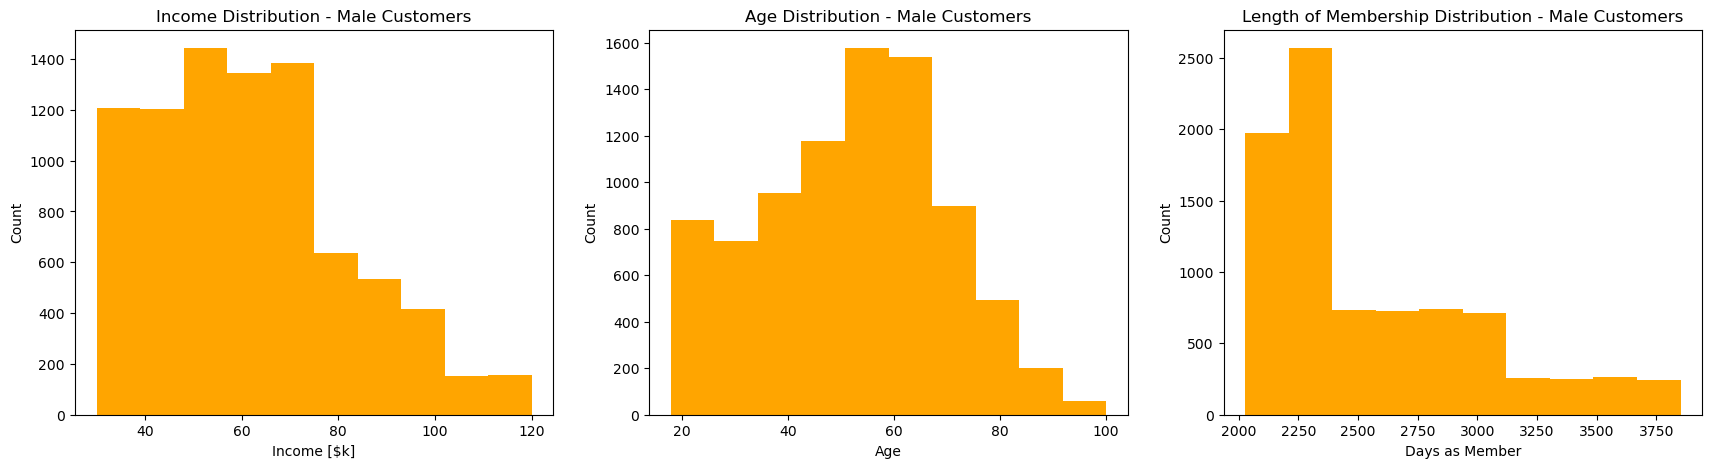

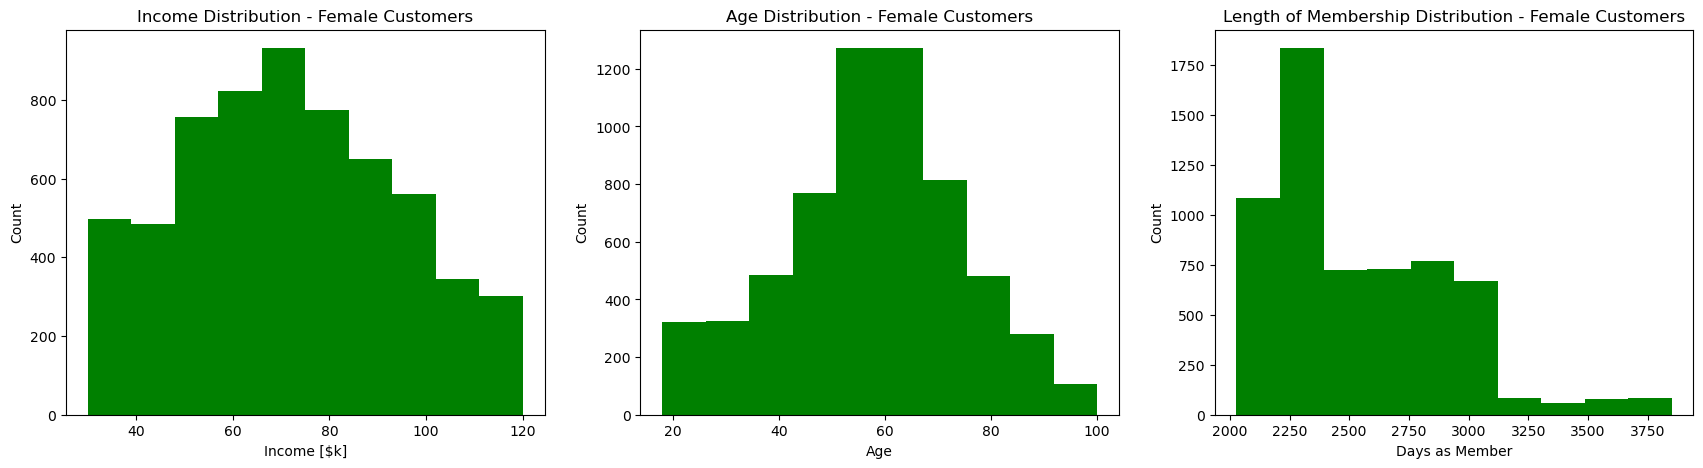

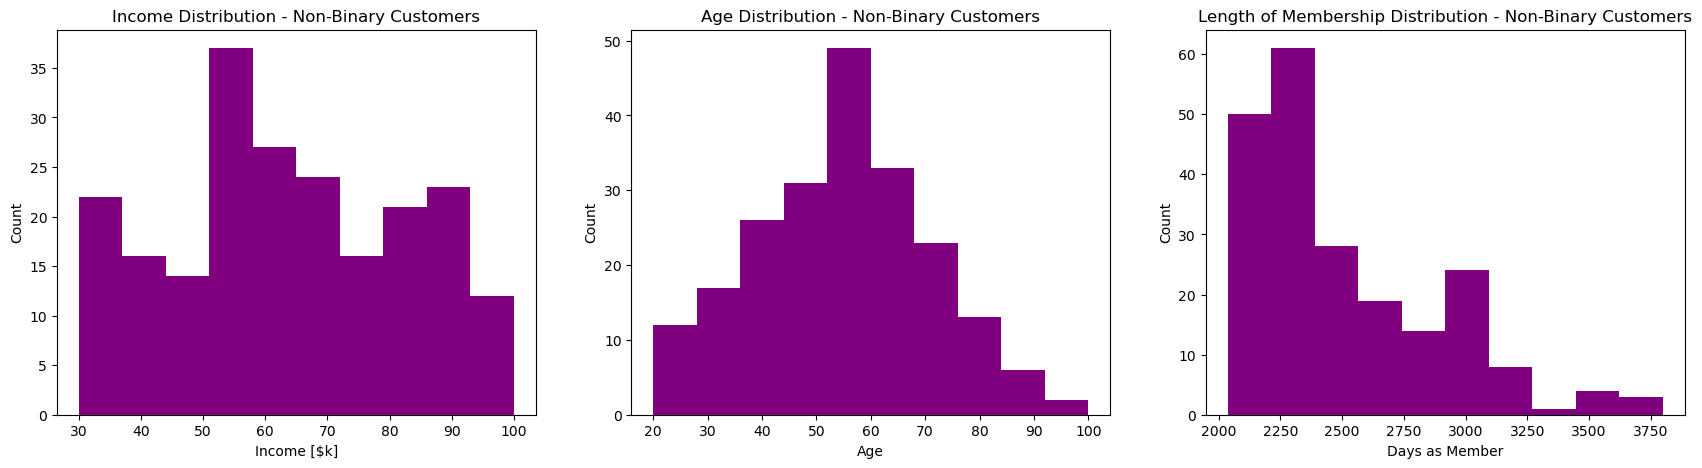

In [57]:
# View distributions by gender
male_customers = cleaned_profile[cleaned_profile['M'] == 1]
female_customers = cleaned_profile[cleaned_profile['F'] == 1]
nb_customers = cleaned_profile[cleaned_profile['O'] == 1]

male = ['orange']
female = ['green']
nb = ['purple']

# MALE
# Chart out plots side by side
fig, ax = plt.subplots(figsize=(21, 5), nrows=1, ncols=3)

# Income Distribution Plot
plt.sca(ax[0])
plt.hist(male_customers['income'] * 1E-3, color=male )
plt.xlabel('Income [$k]')
plt.ylabel('Count')
plt.title('Income Distribution - Male Customers')

# Age Distribution Plot
plt.sca(ax[1])
plt.hist(male_customers['age'], color=male)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution - Male Customers')

# Length of Membership Distribution Plot
plt.sca(ax[2])
plt.hist(male_customers['member_days'], color=male)
plt.xlabel('Days as Member')
plt.ylabel('Count')
plt.title('Length of Membership Distribution - Male Customers')
plt.savefig('IncomeAgeMembership-M')

# FEMALE
# Chart out plots side by side
fig, ax = plt.subplots(figsize=(21, 5), nrows=1, ncols=3)

# Income Distribution Plot
plt.sca(ax[0])
plt.hist(female_customers['income'] * 1E-3, color=female )
plt.xlabel('Income [$k]')
plt.ylabel('Count')
plt.title('Income Distribution - Female Customers')

# Age Distribution Plot
plt.sca(ax[1])
plt.hist(female_customers['age'], color=female)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution - Female Customers')

# Length of Membership Distribution Plot
plt.sca(ax[2])
plt.hist(female_customers['member_days'], color=female)
plt.xlabel('Days as Member')
plt.ylabel('Count')
plt.title('Length of Membership Distribution - Female Customers')
plt.savefig('IncomeAgeMembership-F')

# NB
# Chart out plots side by side
fig, ax = plt.subplots(figsize=(21, 5), nrows=1, ncols=3)

# Income Distribution Plot
plt.sca(ax[0])
plt.hist(nb_customers['income'] * 1E-3, color=nb )
plt.xlabel('Income [$k]')
plt.ylabel('Count')
plt.title('Income Distribution - Non-Binary Customers')

# Age Distribution Plot
plt.sca(ax[1])
plt.hist(nb_customers['age'], color=nb)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution - Non-Binary Customers')

# Length of Membership Distribution Plot
plt.sca(ax[2])
plt.hist(nb_customers['member_days'], color=nb)
plt.xlabel('Days as Member')
plt.ylabel('Count')
plt.title('Length of Membership Distribution - Non-Binary Customers')
plt.savefig('IncomeAgeMembership-NB')

### Cleaned_Portfolio

In [58]:
cleaned_portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,168,bogo,B1,1,1,1,0,1,0,0
1,10,10,120,bogo,B2,1,1,1,1,1,0,0
2,0,0,96,informational,I1,1,1,0,1,0,0,1
3,5,5,168,bogo,B3,1,1,0,1,1,0,0
4,5,20,240,discount,D1,1,0,0,1,0,1,0
5,3,7,168,discount,D2,1,1,1,1,0,1,0
6,2,10,240,discount,D3,1,1,1,1,0,1,0
7,0,0,72,informational,I2,1,1,1,0,0,0,1
8,5,5,120,bogo,B4,1,1,1,1,1,0,0
9,2,10,168,discount,D4,1,1,0,1,0,1,0


Questions of interest:
1. Success rate by offer type
2. Success rate by channel
3. Success rate by offer

I would need to:
1. Merge cleaned_portfolio with offers
2. Engineer offer success variable that accounts for received, viewed, completed events
3. Engineer success rate metrics

### Offers

In [59]:
offers

,customer_id,offer_id,event,hours,offer_received,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,B3,offer received,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,D1,offer received,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,D4,offer received,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,D3,offer received,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,B2,offer received,0,1,0,0
...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,D2,offer completed,714,0,0,1
306506,b895c57e8cd047a8872ce02aa54759d6,D3,offer completed,714,0,0,1
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,D1,offer viewed,714,0,1,0
306509,8431c16f8e1d440880db371a68f82dd0,D3,offer completed,714,0,0,1


Questions of interest:
1. What is the distribution of offers received, viewed, and completed? 
2. What offers can be considered successful?

I would need to:
1. Determine which offers were received and viewed before completion (order by offer, then person)

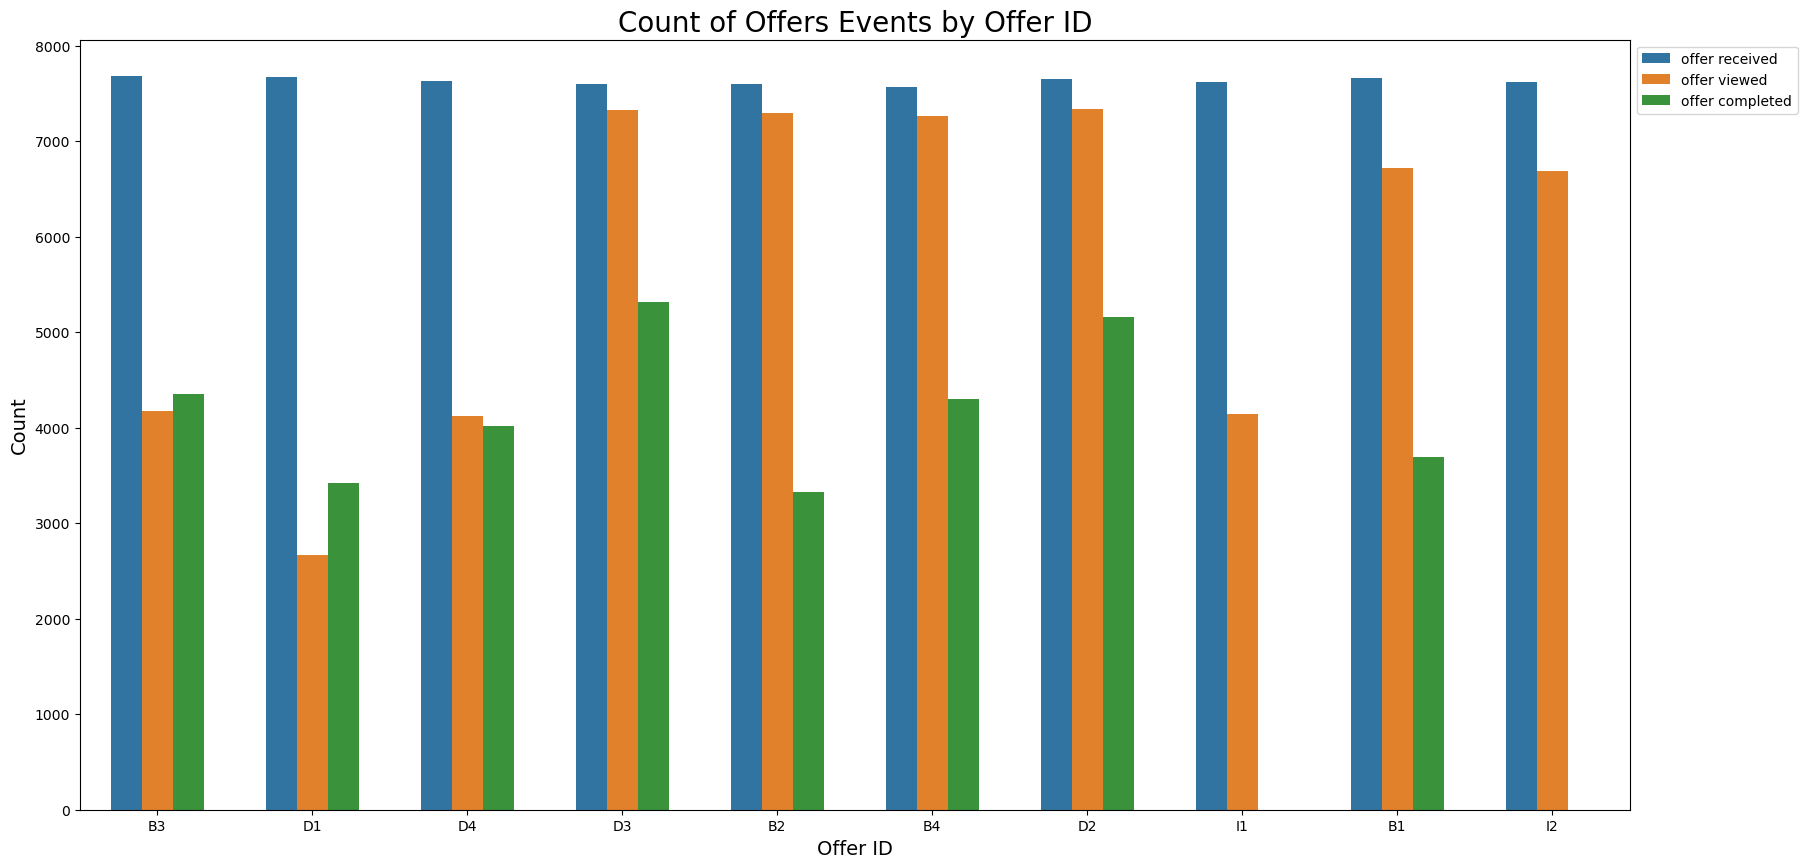

In [60]:
# Distribution of offer events by offer_id
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
ax = sns.countplot(data=offers, x='offer_id', hue='event', width=0.6)
ax.legend().set_title('')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Offer ID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Offers Events by Offer ID', fontsize=20)
plt.savefig('OfferEventsByID')

In [28]:
offers[(offers['offer_id']=='D1')]['offer_viewed'].sum()

2663

In [29]:
offers[(offers['offer_id']=='D1')]['offer_completed'].sum()

3420

We can see from this chart that each offer was sent/received approximately the same number of times. As we would expect, there is more variation in how many times an offer was viewed or completed. This chart also illustrates the point made in the project description: some offers may have been "completed" even though they were not viewed by the customer. Both B3 and D1 have a greater number of offers completed than offers viewed. So how can we determine when customers were successfully influenced by an offer to complete it?

Even though all the offers were received the same number of times (approx.), how many unique times were the offers sent? In other words, was one offer sent to all customers one time while another was sent to all customers another time? Or was an offer sent multiple times to a different subset of customers each time?

In [62]:
unique_offers = offers.drop_duplicates(subset=['customer_id','offer_id'])

In [63]:
unique_offers

,customer_id,offer_id,event,hours,offer_received,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,B3,offer received,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,D1,offer received,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,D4,offer received,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,D3,offer received,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,B2,offer received,0,1,0,0
...,...,...,...,...,...,...,...
257879,670626b55bfb4ba39c85b27cc7cca527,D1,offer received,576,1,0,0
257881,a57890c3bbb7463e9018abb7fecadb15,I2,offer received,576,1,0,0
257882,d087c473b4d247ccb0abfef59ba12b0e,B1,offer received,576,1,0,0
257884,6d5f3a774f3d4714ab0c092238f3a1d7,D2,offer received,576,1,0,0


In [32]:
offers[(offers['offer_id'] == 'B3')].sort_values(by='customer_id')

,customer_id,offer_id,event,hours,offer_received,offer_viewed,offer_completed
222679,0011e0d4e6b944f998e987f904e8c1e5,B3,offer viewed,516,0,1,0
258981,0011e0d4e6b944f998e987f904e8c1e5,B3,offer completed,576,0,0,1
204643,0011e0d4e6b944f998e987f904e8c1e5,B3,offer received,504,1,0,0
207725,0020ccbbb6d84e358d3414a3ff76cffd,B3,offer received,504,1,0,0
273123,0020ccbbb6d84e358d3414a3ff76cffd,B3,offer completed,600,0,0,1
...,...,...,...,...,...,...,...
265668,fffad4f4828548d1b5583907f2e9906b,B3,offer completed,588,0,0,1
294735,fffad4f4828548d1b5583907f2e9906b,B3,offer viewed,666,0,1,0
230690,ffff82501cea40309d5fdd7edcca4a07,B3,offer viewed,534,0,1,0
214717,ffff82501cea40309d5fdd7edcca4a07,B3,offer completed,504,0,0,1


In [33]:
offers['offer_received'].sum()

76277

In [34]:
unique_offers['offer_received'].sum()

63288

This seems to indicate that some customers received the same offer multiple times, so I don't want to drop subsequent offers from the dataset. 

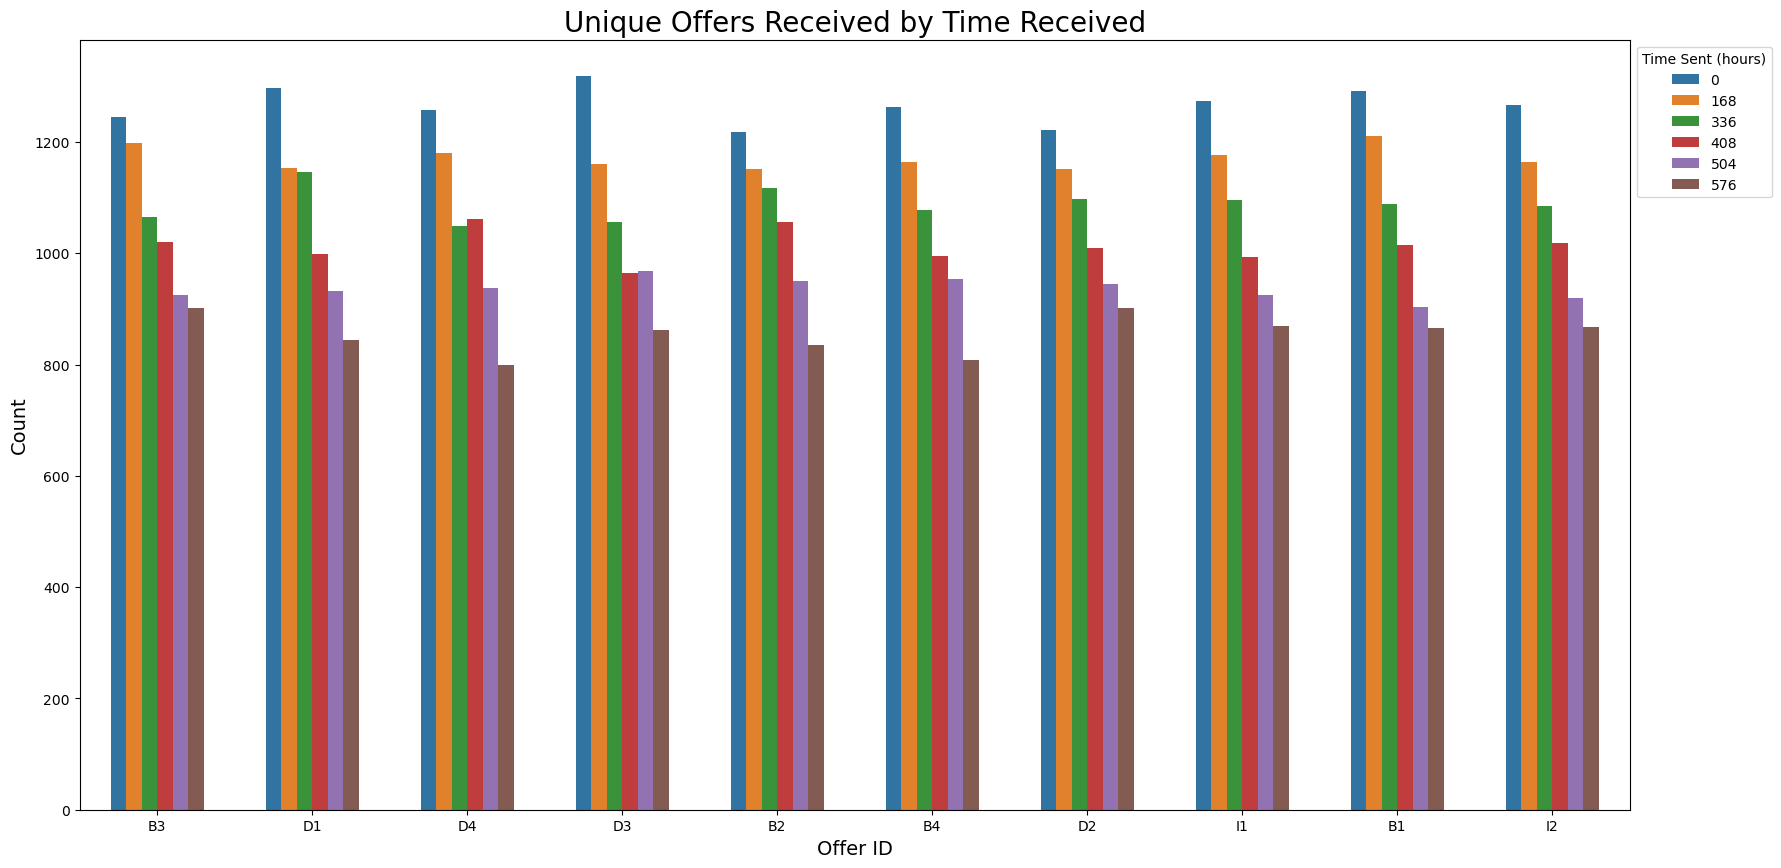

In [64]:
# Offers Received by Time Received
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
ax = sns.countplot(data=unique_offers, x='offer_id', hue='hours', width=0.6)
ax.legend().set_title('Time Sent (hours)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Offer ID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Unique Offers Received by Time Received', fontsize=20)
plt.savefig('UniqueOffersbyTime')

All offers were sent to customers at only 6 distinct times within the duration of the experiment, but not to the same number of customers each time the offers was made. This could mean that not every customer received all offers and some customers may have received the same offer multiple times.

In [66]:
offers.groupby(['customer_id', 'offer_id']).count()

event  hours  offer_received  \
customer_id                      offer_id                                 
0009655768c64bdeb2e877511632db8f B4            3      3               3   
                                 D3            3      3               3   
                                 D4            2      2               2   
                                 I1            2      2               2   
                                 I2            2      2               2   
...                                          ...    ...             ...   
fffad4f4828548d1b5583907f2e9906b I2            2      2               2   
ffff82501cea40309d5fdd7edcca4a07 B3            3      3               3   
                                 D1            3      3               3   
                                 D3            3      3               3   
                                 D4            9      9               9   

                                           offer_viewed  offer_completed  
customer_id                      offer_id                                 
0009655768c64bdeb2e877511632db8f B4                   3                3  
                                 D3                   3                3  
                                 D4                   2                2  
                                 I1                   2                2  
                                 I2                   2                2  
...                                                 ...              ...  
fffad4f4828548d1b5583907f2e9906b I2                   2                2  
ffff82501cea40309d5fdd7edcca4a07 B3                   3                3  
                                 D1                   3                3  
                                 D3                   3                3  
                                 D4                   9                9  

[63288 rows x 5 columns]

This view confirms the previous observation, but still does not necessarily confirm if an offer was successful even if there are 3 events for each unique offer. Looking more closely at the customer with 9 events for one offer will provide more insight. 

In [67]:
offers[(offers['offer_id']=='D4') & (offers['customer_id']=='ffff82501cea40309d5fdd7edcca4a07')]


,customer_id,offer_id,event,hours,offer_received,offer_viewed,offer_completed
112214,ffff82501cea40309d5fdd7edcca4a07,D4,offer received,336,1,0,0
133074,ffff82501cea40309d5fdd7edcca4a07,D4,offer viewed,354,0,1,0
143788,ffff82501cea40309d5fdd7edcca4a07,D4,offer completed,384,0,0,1
152030,ffff82501cea40309d5fdd7edcca4a07,D4,offer received,408,1,0,0
168022,ffff82501cea40309d5fdd7edcca4a07,D4,offer viewed,414,0,1,0
168024,ffff82501cea40309d5fdd7edcca4a07,D4,offer completed,414,0,0,1
246495,ffff82501cea40309d5fdd7edcca4a07,D4,offer received,576,1,0,0
258362,ffff82501cea40309d5fdd7edcca4a07,D4,offer completed,576,0,0,1
262475,ffff82501cea40309d5fdd7edcca4a07,D4,offer viewed,582,0,1,0


Examining just the customer with 9 events for one offer shows that the customer received the offer 3 different times and completed the offer 3 times. However, only 2 completions can be considered successful because the last offer was completed before being viewed. So the offer cannot be considered successful. The order of events matters.

Since the same offer may have been received multiple times, I need to determine the start time (when each instance of the offer was received). Then I need to determine the end time of the offer, since each offer has a limited duration according to the portfolio df. Then I need to determine if each offer received was completed within that timeframe and after the time viewed. Using the 'hours' data, I want to mark offers as successful where the completed hour is:

start hour <= viewed hour < completed hour < end hour

where start hour = hour received & end hour = hour received + duration 

In [68]:
def dfs_by_event(offers):
    '''
    segregate offers data by event type 

    INPUT:
    offers - the original dataframe

    OUTPUT:
    offers_received - new df where the event 'offer_received' == 1
    offers_viewed - new df where the event 'offer_viewed' == 1
    offers_completed - new df where the event 'offer_completed' == 1
    '''
    # received
    offers_received = offers[(offers['offer_received']==1)].drop(['event','offer_received','offer_viewed','offer_completed'], axis=1)
    offers_received.rename(columns={"hours": "start_time"}, inplace=True)

    # viewed
    offers_viewed = offers[(offers['offer_viewed']==1)].drop(['event','offer_received','offer_viewed','offer_completed'], axis=1)
    offers_viewed.rename(columns={"hours": "viewed_time"}, inplace=True)

    # completed
    offers_completed = offers[(offers['offer_completed']==1)].drop(['event','offer_received','offer_viewed','offer_completed'], axis=1)
    offers_completed.rename(columns={"hours": "completed_time"}, inplace=True)

    return offers_received, offers_viewed, offers_completed

In [69]:
offers_received, offers_viewed, offers_completed = dfs_by_event(offers)

In [70]:
offers_received

,customer_id,offer_id,start_time
0,78afa995795e4d85b5d9ceeca43f5fef,B3,0
1,a03223e636434f42ac4c3df47e8bac43,D1,0
2,e2127556f4f64592b11af22de27a7932,D4,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,D3,0
4,68617ca6246f4fbc85e91a2a49552598,B2,0
...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,B1,576
257883,cb23b66c56f64b109d673d5e56574529,D4,576
257884,6d5f3a774f3d4714ab0c092238f3a1d7,D2,576
257885,9dc1421481194dcd9400aec7c9ae6366,B1,576


In [71]:
offers_viewed.shape

(57725, 3)

In [72]:
offers_completed.head()

,customer_id,offer_id,completed_time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,D4,0
12672,fe97aa22dd3e48c8b143116a8403dd52,D3,0
12679,629fc02d56414d91bca360decdfa9288,B3,0
12692,676506bad68e4161b9bbaffeb039626b,B1,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,B2,0


In [73]:
def merge_offers_customers(cleaned_portfolio, cleaned_profile, offers_received):
    '''
    merge customer profile data, offer portfolio data, and offers received data to engineer new data features 

    INPUT:
    cleaned_profile - cleaned customer profile data
    cleaned_portfolio - cleaned offer data
    offers_received - cleaned offer data where offers_received == 1

    OUTPUT:
    cust_off_received - df with 1 row per offer received merged to include offer details and customer profile details
    '''
    # merge offer info with offers_received to calculate duration for each offer
    portfolio_received = offers_received.merge(cleaned_portfolio, on='offer_id', how='left')
    portfolio_received['end_time']= portfolio_received['start_time'] + portfolio_received['duration'] 

    # merge with cleaned_profile to include customer profile data
    cust_off_received = portfolio_received.merge(cleaned_profile, on='customer_id', how='left')

    # drop rows with NAN values (these are customers that were dropped from the profile cleaning step)
    cust_off_received.dropna(inplace=True)
    cust_off_received.reset_index(drop=True, inplace=True)

    return cust_off_received

In [74]:
cust_off_received = merge_offers_customers(cleaned_portfolio, cleaned_profile, offers_received)
cust_off_received

,customer_id,offer_id,start_time,reward,difficulty,duration,offer_type,email,mobile,social,...,informational,end_time,gender,age,became_member_on,income,F,M,O,member_days
0,78afa995795e4d85b5d9ceeca43f5fef,B3,0,5,5,168,bogo,1,1,0,...,0,168,F,75.0,2017-05-09,100000.0,1.0,0.0,0.0,2471.0
1,e2127556f4f64592b11af22de27a7932,D4,0,2,10,168,discount,1,1,0,...,0,168,M,68.0,2018-04-26,70000.0,0.0,1.0,0.0,2119.0
2,389bc3fa690240e798340f5a15918d5c,B4,0,5,5,120,bogo,1,1,1,...,0,120,M,65.0,2018-02-09,53000.0,0.0,1.0,0.0,2195.0
3,2eeac8d8feae4a8cad5a6af0499a211d,I1,0,0,0,96,informational,1,1,0,...,1,96,M,58.0,2017-11-11,51000.0,0.0,1.0,0.0,2285.0
4,aa4862eba776480b8bb9c68455b8c2e1,D1,0,5,20,240,discount,1,0,0,...,0,240,F,61.0,2017-09-11,57000.0,1.0,0.0,0.0,2346.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66473,d087c473b4d247ccb0abfef59ba12b0e,B1,576,10,10,168,bogo,1,1,1,...,0,744,M,56.0,2016-10-23,51000.0,0.0,1.0,0.0,2669.0
66474,cb23b66c56f64b109d673d5e56574529,D4,576,2,10,168,discount,1,1,0,...,0,744,M,60.0,2018-05-05,113000.0,0.0,1.0,0.0,2110.0
66475,6d5f3a774f3d4714ab0c092238f3a1d7,D2,576,3,7,168,discount,1,1,1,...,0,744,F,45.0,2018-06-04,54000.0,1.0,0.0,0.0,2080.0
66476,9dc1421481194dcd9400aec7c9ae6366,B1,576,10,10,168,bogo,1,1,1,...,0,744,F,83.0,2016-03-07,50000.0,1.0,0.0,0.0,2899.0


Now validated that the viewed_time was within the start and end time of each offer received, since the same offer may have been received multiple times. 

In [75]:
def validate_success(cust_off_received, offers_viewed, offers_completed):
    '''
    Validate that viewed_time and completed_time are within the start and end time of each offer received, 
    since the same offer may have been received multiple times.

    Input:
    cust_off_viewed - the df containing customer profile, offer portfolio, and offer event data for all offers received
    offers_viewed - the df containing offer event data for all offers viewed
    offers_completed - the df containing offer event data for all offers completed

    Output:
    cust_off_success - a df containing customer profile data, offer portfolio data, and offer event data for each offer received by each customer,
        with the newly engineered binary 'success' variable

    '''
    # Create a column for the new validated 'success' variable
    cust_off_received['success'] = np.nan
    
    # Iterate through each offer received to validate success
    for i in range(cust_off_received.shape[0]):
        cust_id = cust_off_received.iloc[i,0]
        off_id = cust_off_received.iloc[i,1]
        start = cust_off_received.iloc[i,2]
        end = cust_off_received.iloc[i,14]
        
        # Isolate offers viewed and completed for each customer
        # Create a .copy(), otherwise it will cause a SettingWithCopy warning:
        # https://www.practicaldatascience.org/html/views_and_copies_in_pandas.html
        cust_views = offers_viewed[(offers_viewed['offer_id'] == off_id) & (offers_viewed['customer_id'] == cust_id)].copy()
        cust_comps = offers_completed[(offers_completed['offer_id'] == off_id) & (offers_completed['customer_id'] == cust_id)].copy()

        # Validate that the offer was viewed between the start and end time
        cust_views['viewed'] = np.logical_and(cust_views['viewed_time'] >= start, cust_views['viewed_time'] <= end)

        # Select the value only when 'viewed' is True
        for v in range(cust_views.shape[0]):
            if cust_views.iloc[v,3] == True:                   # column index 3 = 'viewed'
                view_time = cust_views.iloc[v,2]               # column index 2 = 'viewed_time'
                
        # Validate that the offer was completed between the viewed time and end time
        completed = np.logical_and(cust_comps['completed_time'] >= view_time, cust_comps['completed_time'] <= end)

        # Set success = 1 when completed > 0, else 0 
        if completed.sum() > 0:
            cust_off_received.iloc[i, 23] = 1
        else:
            cust_off_received.iloc[i,23] = 0
    
    cust_off_success = cust_off_received.copy()
    return cust_off_success

In [76]:
cust_off_success = validate_success(cust_off_received, offers_viewed, offers_completed)
cust_off_success

,customer_id,offer_id,start_time,reward,difficulty,duration,offer_type,email,mobile,social,...,end_time,gender,age,became_member_on,income,F,M,O,member_days,success
0,78afa995795e4d85b5d9ceeca43f5fef,B3,0,5,5,168,bogo,1,1,0,...,168,F,75.0,2017-05-09,100000.0,1.0,0.0,0.0,2471.0,1.0
1,e2127556f4f64592b11af22de27a7932,D4,0,2,10,168,discount,1,1,0,...,168,M,68.0,2018-04-26,70000.0,0.0,1.0,0.0,2119.0,0.0
2,389bc3fa690240e798340f5a15918d5c,B4,0,5,5,120,bogo,1,1,1,...,120,M,65.0,2018-02-09,53000.0,0.0,1.0,0.0,2195.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,I1,0,0,0,96,informational,1,1,0,...,96,M,58.0,2017-11-11,51000.0,0.0,1.0,0.0,2285.0,0.0
4,aa4862eba776480b8bb9c68455b8c2e1,D1,0,5,20,240,discount,1,0,0,...,240,F,61.0,2017-09-11,57000.0,1.0,0.0,0.0,2346.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66473,d087c473b4d247ccb0abfef59ba12b0e,B1,576,10,10,168,bogo,1,1,1,...,744,M,56.0,2016-10-23,51000.0,0.0,1.0,0.0,2669.0,0.0
66474,cb23b66c56f64b109d673d5e56574529,D4,576,2,10,168,discount,1,1,0,...,744,M,60.0,2018-05-05,113000.0,0.0,1.0,0.0,2110.0,0.0
66475,6d5f3a774f3d4714ab0c092238f3a1d7,D2,576,3,7,168,discount,1,1,1,...,744,F,45.0,2018-06-04,54000.0,1.0,0.0,0.0,2080.0,0.0
66476,9dc1421481194dcd9400aec7c9ae6366,B1,576,10,10,168,bogo,1,1,1,...,744,F,83.0,2016-03-07,50000.0,1.0,0.0,0.0,2899.0,0.0


In [77]:
cust_off_success.describe()

,start_time,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,end_time,age,income,F,M,O,member_days,success
count,66478.000000,66478.000000,66478.000000,66478.000000,66478.0,66478.000000,66478.000000,66478.000000,66478.000000,66478.000000,66478.000000,66478.000000,66478.000000,66478.000000,66478.000000,66478.000000,66478.000000,66478.000000,66478.000000
mean,332.604952,4.199510,7.714026,156.176901,1.0,0.898884,0.598589,0.799573,0.399155,0.400885,0.199961,488.781853,54.353124,65370.318000,0.412663,0.573558,0.013779,2549.911911,0.404540
std,196.525918,3.398307,5.547032,52.901254,0.0,0.301485,0.490188,0.400323,0.489728,0.490081,0.399974,203.313551,17.376797,21623.306683,0.492317,0.494563,0.116573,419.236017,0.490806
min,0.000000,0.000000,0.000000,72.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.000000,18.000000,30000.000000,0.000000,0.000000,0.000000,2028.000000,0.000000
25%,168.000000,2.000000,5.000000,120.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,336.000000,42.000000,49000.000000,0.000000,0.000000,0.000000,2235.000000,0.000000
50%,408.000000,5.000000,10.000000,168.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,528.000000,55.000000,64000.000000,0.000000,1.000000,0.000000,2386.000000,0.000000
75%,504.000000,5.000000,10.000000,168.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,672.000000,66.000000,80000.000000,1.000000,1.000000,0.000000,2826.000000,1.000000
max,576.000000,10.000000,20.000000,240.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,816.000000,100.000000,120000.000000,1.000000,1.000000,1.000000,3851.000000,1.000000


In [78]:
cust_off_success.columns.to_list()

['customer_id',
 'offer_id',
 'start_time',
 'reward',
 'difficulty',
 'duration',
 'offer_type',
 'email',
 'mobile',
 'social',
 'web',
 'bogo',
 'discount',
 'informational',
 'end_time',
 'gender',
 'age',
 'became_member_on',
 'income',
 'F',
 'M',
 'O',
 'member_days',
 'success']

In [57]:
cust_off_success.to_csv('cust_off_success.csv', index=False)

In [79]:
data = pd.read_csv('cust_off_success.csv')

In [80]:
data.head()

,customer_id,offer_id,start_time,reward,difficulty,duration,offer_type,email,mobile,social,...,end_time,gender,age,became_member_on,income,F,M,O,member_days,success
0,78afa995795e4d85b5d9ceeca43f5fef,B3,0,5,5,168,bogo,1,1,0,...,168,F,75.0,2017-05-09,100000.0,1.0,0.0,0.0,2430.0,1.0
1,e2127556f4f64592b11af22de27a7932,D4,0,2,10,168,discount,1,1,0,...,168,M,68.0,2018-04-26,70000.0,0.0,1.0,0.0,2078.0,0.0
2,389bc3fa690240e798340f5a15918d5c,B4,0,5,5,120,bogo,1,1,1,...,120,M,65.0,2018-02-09,53000.0,0.0,1.0,0.0,2154.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,I1,0,0,0,96,informational,1,1,0,...,96,M,58.0,2017-11-11,51000.0,0.0,1.0,0.0,2244.0,0.0
4,aa4862eba776480b8bb9c68455b8c2e1,D1,0,5,20,240,discount,1,0,0,...,240,F,61.0,2017-09-11,57000.0,1.0,0.0,0.0,2305.0,0.0


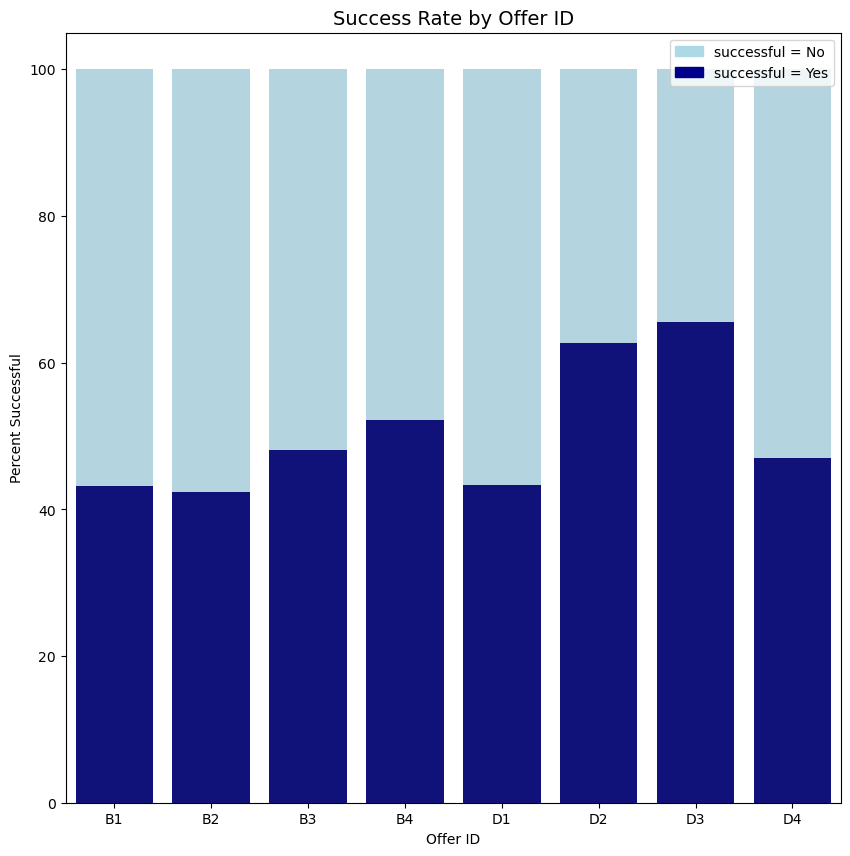

In [82]:
# Success rate visualiztion 

# https://python-graph-gallery.com/stacked-and-percent-stacked-barplot/

# set the figure size
plt.figure(figsize=(10, 10))

# from raw value to percentage
total = data.groupby('offer_id')['customer_id'].count().reset_index().rename(columns={"customer_id": "count"})
successful = data[data.success== 1].groupby('offer_id')['customer_id'].count().reset_index().rename(columns={"customer_id": "count"})
successful['count'] = [i / j * 100 for i,j in zip(successful['count'], total['count'])]
total['count'] = [i / j * 100 for i,j in zip(total['count'], total['count'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="offer_id",  y="count", data=total, color='lightblue')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="offer_id", y="count", data=successful, color='darkblue')

# add legend
top_bar = mpatches.Patch(color='lightblue', label='successful = No')
bottom_bar = mpatches.Patch(color='darkblue', label='successful = Yes')
plt.legend(handles=[top_bar, bottom_bar])
plt.xlabel("Offer ID")
plt.ylabel("Percent Successful")
plt.title('Success Rate by Offer ID', fontsize=14)

plt.savefig('SuccessRateByID')

# Modeling

I will test different models and parameters to find the best predictive model for offer success. Given that there is an uneven class distribution with a larger number of actual negatives in this data set, accuracy may not be the best metric by which to evaluate the performance of my models. Instead, I've chosen to use the F1 score, which is a balanced measure of precision and recall. I'll still include the accuracy score for comparison.

First I will use the DummyClassifier to establish a baseline model against which I can evaluate my more advanced models. Since I will be predicting a binary independent variable, I will then build a Logistic Regression model. Finally, I will build a Random Forest Classifier model and compare the performance of all models to find the best predictor.

https://medium.com/@preethiprakash29/understanding-baseline-models-in-machine-learning-3ed94f03d645#:~:text=A%20baseline%20model%20is%20a,a%20baseline%20model%20for%20classification

In [28]:
# Load Data
def load_data():
    '''
    Input: none
    Output: 
    X - dataframe with dependent variables, excluding string variables
    y - dataframe with the independent variable 'success'

    '''
    data = pd.read_csv('cust_off_success.csv')

    # Drop independent variable, string variables, and multi-colinear variables 
    X = data.drop(['success','offer_id','offer_type','gender','customer_id', 'email','informational','became_member_on', 'M', 'O'] , axis=1)
    y = data['success']
    
    return X, y

In [29]:
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4)

In [30]:
# Baseline Model

# Instantiate
baseline_model = DummyClassifier(strategy='constant', constant=1)
# Fit (on train)
baseline_model.fit(X_train, y_train)
# Predict (on test)
preds = baseline_model.predict(X_test)
# Score
confusion_mat = confusion_matrix(y_test, preds)
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds) 

print("Confusion Matrix:\n", confusion_mat)
print("Accuracy:", accuracy)
print("F1-score:", f1)

Confusion Matrix:
 [[    0 11866]
 [    0  8078]]
Accuracy: 0.40503409546730845
F1-score: 0.5765469987866676


In [87]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [32]:
# Build Model

def model_A():
    '''
    Creates a logistic regression model using the 'liblinear' solver and random state set to 43.
    Other parameters are tested using GridSearchCV to fine tune the model. 

    Inputs: none
    Output:
    cv - GridSearch object for cross validating the parameters specified in the function
    '''
    log_model = LogisticRegression(random_state=43, solver='liblinear')

    # specify parameters for grid search
    parameters = {
        'C' : [1.0, 0.1, 0.01],
        'penalty' : ['l1', 'l2']
    }

    # Create grid search object for cross validation (cv) 
    cv = GridSearchCV(log_model, param_grid=parameters)

    return cv

In [33]:
# Evaluate

def display_results(cv, y_test, preds):
    '''
    Function to display the performance metrics of each model, including the best parameters from GridSearchCV

    Inputs: 
    cv - GridSearch object for cross validating the parameters specified in the function, resulting from the model function
    y_test - test data for the independent variable from train_test_split
    preds - model predictions 

    Outputs:
    Confusion Matrix results
    Accuracy score
    F1 score
    Best Parameters based on GridSearchCV
    '''
    confusion_mat = confusion_matrix(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds) 

    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("F1-score:", f1)
    print("\nBest Parameters:", cv.best_params_)

In [34]:
# Main program to run through all functions

def main(model_name):
    '''
    This function executes the load_data() function, model function, and display_results() function

    Input: 
    model_name - name of the model to be run (e.g. model_A, model_B)

    Output: 
    display_results - function that produces the evaluation metrics and best parametres
    '''
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4)

    # Instantiate
    model = model_name()
    # Fit on train data
    model.fit(X_train, y_train)
    # Predict on test data
    y_pred = model.predict(X_test)
    # Sore
    display_results(model, y_test, y_pred)


main(model_A)
# When specifying parameters, I kept getting error codes especially for the solver and max_iter parameters. 
# So based on the documentation, I decided to use liblinear and remove the max_iter param from the parameters dictionary.
# I was then able to run the code without error.

Confusion Matrix:
 [[8984 2882]
 [3060 5018]]
Accuracy: 0.702065784195748
F1-score: 0.6281136562773814

Best Parameters: {'C': 1.0, 'penalty': 'l1'}


In [88]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [36]:
#Random Forest Classifier Model 

# Build Model
def model_B():
    '''
    
    '''
    rfclf_model = RandomForestClassifier(random_state=43)
    
    
    # specify parameters for grid search
    parameters = {
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [2, 4, 6],
        'n_estimators': [50, 100, 200]
    }

    # create grid search object for cross validation (cv)
    cv =  GridSearchCV(rfclf_model, param_grid=parameters)
    
    return cv

In [37]:
main(model_B)

Confusion Matrix:
 [[9167 2699]
 [2727 5351]]
Accuracy: 0.7279382270357
F1-score: 0.6635664682539683

Best Parameters: {'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
